In [2]:
#| default_exp learner

In [3]:
#|export
import math,torch,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from operator import attrgetter
from functools import partial
from copy import copy

from torch import optim
import torch.nn.functional as F

from miniai.conv import *

from fastprogress import progress_bar,master_bar

In [4]:
import matplotlib as mpl
import torchvision.transforms.functional as TF
from contextlib import contextmanager
from torch import nn,tensor
from datasets import load_dataset,load_dataset_builder
from miniai.datasets import *
from miniai.conv import *
import logging
from fastcore.test import test_close

In [5]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

In [6]:
logging.disable(logging.WARNING)

## Learner

In [7]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

In [8]:
@inplace
def transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

In [9]:
bs = 1024
tds = dsd.with_transform(transformi)

In [10]:
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

(torch.Size([1024, 784]), tensor([5, 4, 9, 4, 3, 0, 6, 5, 7, 6]))

In [11]:
class Learner:
    def __init__(self, model, dls, loss_func, lr, opt_func=optim.SGD): fc.store_attr()

    def one_batch(self):
        self.xb,self.yb = to_device(self.batch)
        self.preds = self.model(self.xb)
        self.loss = self.loss_func(self.preds, self.yb)
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()
        with torch.no_grad(): self.calc_stats()
    
    def calc_stats(self):
        acc = (self.preds.argmax(dim=1)==self.yb).float().sum()
        self.accs.append(acc)
        n = len(self.xb)
        self.losses.append(self.loss*n)
        self.ns.append(n)

    def one_epoch(self, train):
        self.model.training = train
        dl = self.dls.train if train else self.dls.valid
        for self.num,self.batch in enumerate(dl): self.one_batch()
        n = sum(self.ns)
        print(self.epoch, self.model.training, sum(self.losses).item()/n, sum(self.accs).item()/n)

    def fit(self, n_epochs):
        self.accs,self.losses,self.ns = [],[],[]
        self.model.to(def_device)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        self.n_epochs = n_epochs
        for self.epoch in range(n_epochs):
            self.one_epoch(True)
            with torch.no_grad(): self.one_epoch(False)

In [12]:
m,nh = 28*28,50
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [13]:
learn = Learner(model, dls, F.cross_entropy, lr=0.2)
learn.fit(1)

0 True 1.1753045572916667 0.5986833333333333
0 False 1.12032890625 0.6135285714285714


### Basic Callback Learner

In [14]:
#|export 
class CancelFitException(Exception): pass
class CancelBatchException(Exception): pass
class CancelEpochException(Exception): pass

In [15]:
#|export 
def run_cbs(cbs, method_nm):
    for cb in sorted(cbs, key=attrgetter('order')):
        method = getattr(cb, method_nm, None)
        if method is not None: method()

In [16]:
#|export
class Callback(): order = 0

In [17]:
class CompletionCB(Callback):
    def before_fit(self): self.count = 0
    def after_batch(self): self.count += 1
    def after_fit(self): print(f'Completed {self.count} batches')

In [18]:
cbs = [CompletionCB()]
run_cbs(cbs, 'before_fit')
run_cbs(cbs, 'after_batch')
run_cbs(cbs, 'after_fit')

Completed 1 batches


In [19]:
class Learner():
    def __init__(self, model, dls, loss_func, lr, cbs, opt_func=optim.SGD):
        fc.store_attr()
        for cb in cbs: cb.learn = self

    def one_batch(self):
        self.preds = self.model(self.batch[0])
        self.loss = self.loss_func(self.preds, self.batch[1])
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()

    def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        try:
            self.callback('before_epoch')
            for self.iter, self.batch in enumerate(self.dl):
                try:
                    self.callback('before_batch')
                    self.one_batch()
                    self.callback('after_batch')
                except CancelBatchException: pass
            self.callback('after_epoch')
        except CancelEpochException: pass

    def fit(self, n_epochs):
        self.n_epochs = n_epochs
        self.epochs = range(n_epochs)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        try:
            self.callback('before_fit')
            for self.epoch in self.epochs:
                self.one_epoch(True)
                self.one_epoch(False)
            self.callback('after_fit')
        except CancelFitException: pass

    def callback(self, method_nm): run_cbs(self.cbs, method_nm)


In [20]:
m,nh = 28*28,50
def get_model(): return nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [21]:
model = get_model()
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=[CompletionCB()])
learn.fit(1)

Completed 64 batches


In [22]:
class SingleBatchCB(Callback):
    order = 1
    def after_batch(self): raise CancelEpochException()

In [23]:
learn = Learner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=[SingleBatchCB(), CompletionCB()])
learn.fit(1)

Completed 2 batches


### Metrics

In [24]:
#|export
class Metric:
    def __init__(self): self.reset()
    def reset(self): self.vals,self.ns = [],[]
    def add(self, inp, targ=None, n=1):
        self.last = self.calc(inp, targ)
        self.vals.append(self.last)
        self.ns.append(n)
    @property
    def value(self):
        ns = tensor(self.ns)
        return (tensor(self.vals)*ns).sum()/ns.sum()
    def calc(self, inps, targs): return inps

In [25]:
#|export
class Accuracy(Metric):
    def calc(self, inps, targs): return (inps==targs).float().mean()

In [26]:
acc = Accuracy()
acc.add(tensor([0, 1, 2, 0, 1, 2]), tensor([0, 1, 1, 2, 1, 0]))
acc.add(tensor([1, 1, 2, 0, 1]), tensor([0, 1, 1, 2, 1]))
acc.value

tensor(0.45)

In [27]:
loss = Metric()
loss.add(0.6, n=32)
loss.add(0.9, n=2)
loss.value, round((0.6*32+0.9*2)/(32+2), 2)

(tensor(0.62), 0.62)

### Some callback

In [28]:
#|export 
class DeviceCB(Callback):
    def __init__(self, device=def_device): fc.store_attr()
    def before_fit(self): self.learn.model.to(self.device)
    def before_batch(self): self.learn.batch = to_device(self.learn.batch, device=self.device)

In [29]:
#|export
from torcheval.metrics import MulticlassAccuracy,Mean

In [30]:
metric = MulticlassAccuracy()
metric.update(tensor([0, 2, 1, 3]), tensor([0, 1, 2, 3]))
metric.compute()

tensor(0.50)

In [31]:
metric.reset()
metric.compute()

tensor(nan)

In [32]:
#|export
def to_cpu(x):
    if isinstance(x, Mapping): return {k:to_cpu(v) for k,v in x.items()}
    if isinstance(x, list): return [to_cpu(o) for o in x]
    if isinstance(x, tuple): return tuple(to_cpu(list(x)))
    return x.detach().cpu()

In [33]:
#|export 
class MetricCB(Callback):
    def __init__(self, *ms, **metrics):
        for o in ms: metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()
    
    def _log(self, d): print(d)
    def before_fit(self): self.learn.metrics = self
    def before_epoch(self): [o.reset() for o in self.all_metrics.values()]
    def after_epoch(self): 
        log = {k:f'{v.compute():.3f}' for k,v in self.all_metrics.items()}
        log['epoch'] = self.learn.epoch
        log['train'] = self.learn.model.training
        self._log(log)

    def after_batch(self):
        x,y = to_cpu(self.learn.batch)
        for m in self.metrics.values(): m.update(to_cpu(self.learn.preds), y)
        self.loss.update(to_cpu(self.learn.loss), weight=len(x))

In [34]:
model = get_model()
metrics = MetricCB(accuracy=MulticlassAccuracy())
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=[DeviceCB(), metrics])
learn.fit(1)

{'accuracy': '0.611', 'loss': '1.187', 'epoch': 0, 'train': True}
{'accuracy': '0.684', 'loss': '0.825', 'epoch': 0, 'train': False}


### Flexible learner

In [35]:
#|export
class Learner():
    def __init__(self, model, dls, loss_func, lr, cbs, opt_func=optim.SGD):
        fc.store_attr()
        for cb in cbs: cb.learn = self

    @contextmanager
    def callback_ctx(self, nm):
        try:
            self.callback(f'before_{nm}')
            yield
            self.callback(f'after_{nm}')
        except globals()[f'Cancel{nm.title()}Exception']: pass

    def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        with self.callback_ctx('epoch'):
            for self.iter,self.batch in enumerate(self.dl):
                with self.callback_ctx('batch'):
                    self.predict()
                    self.get_loss()
                    if self.model.training:
                        self.backward()
                        self.step()
                        self.zero_grad()

    def fit(self, n_epochs):
        self.n_epochs = n_epochs
        self.epochs = range(n_epochs)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        with self.callback_ctx('fit'):
            for self.epoch in self.epochs:
                self.one_epoch(True)
                self.one_epoch(False)

    def __getattr__(self, name):
        if name in ('predict', 'get_loss', 'backward', 'step', 'zero_grad'): return partial(self.callback, name)
        raise AttributeError(name)
    
    def callback(self, method_nm): run_cbs(self.cbs, method_nm)

In [36]:
#|export
class TrainCB(Callback):
    def predict(self): self.learn.preds = self.learn.model(self.learn.batch[0])
    def get_loss(self): self.learn.loss = self.learn.loss_func(self.learn.preds, self.learn.batch[1])
    def backward(self): self.learn.loss.backward()
    def step(self): self.learn.opt.step()
    def zero_grad(self): self.learn.opt.zero_grad()

In [37]:
#|export
class ProgressCB(Callback):
    order = MetricCB.order+1
    def __init__(self, plot=False): self.plot = plot
    def before_fit(self):
        self.learn.epochs = self.mbar = master_bar(self.learn.epochs)
        if hasattr(self.learn, 'metrics'): self.learn.metrics._log = self._log
        self.losses = []
    def _log(self, d): self.mbar.write(str(d))
    def before_epoch(self): self.learn.dl = progress_bar(self.learn.dl, leave=False, parent=self.mbar)
    def after_epoch(self):
        self.learn.dl.comment = f'{self.learn.loss:.3f}'
        if self.plot and hasattr(self.learn, 'metrics') and self.learn.model.training:
            self.losses.append(self.learn.loss.item())
            self.mbar.update_graph([[fc.L.range(self.losses), self.losses]])

In [38]:
model = get_model()

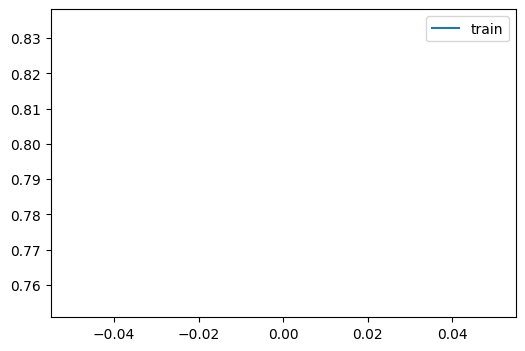

In [39]:
metrics = MetricCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)